<a href="https://colab.research.google.com/github/ioanabuze/DE_Group_Project_2020/blob/master/Amazon_Review_Weak_Labelling_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code here to push the Notebook to Git
# HEllo! :)
# have been changed again

In [8]:
# Import Libraries, OS and Setup 
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from pyspark.sql import SQLContext

In [4]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [9]:
import pyspark

number_cores = 8
memory_gb = 24
conf = (
    pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .set('spark.driver.memory', '{}g'.format(memory_gb))
)
sc = pyspark.SparkContext(conf=conf)

In [10]:
rdd = sc.parallelize([1, 4, 9])
sum_squares = rdd.map(lambda elem: float(elem)**2).sum()

In [11]:
number_cores = int(os.environ['NUM_CPUS'])
memory_gb = int(os.environ['AVAILABLE_MEMORY_MB']) // 1024

In [14]:
sum_squares

98.0

In [83]:
# Import the Data
#sqlContext = SQLContext(sc)

#amazon_reviews_dataset_sql_context = sqlContext.read.csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv",header=True)
amazon_reviews_dataset_pd_df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
#amazon_reviews_dataset_rdd = amazon_reviews_dataset_sql_context.rdd

In [ ]:
amazon_reviews_dataset_pd_df

In [80]:
amazon_reviews_dataset_sql_context=amazon_reviews_dataset_sql_context.withColumnRenamed("reviews.title","reviews_title")
amazon_reviews_dataset_sql_context=amazon_reviews_dataset_sql_context.withColumnRenamed("reviews.text","reviews_text")
amazon_reviews_dataset_sql_context=amazon_reviews_dataset_sql_context.withColumnRenamed("reviews.rating","reviews_rating")

In [81]:
amazon_reviews_dataset_sql_context.printSchema()

root
 |-- id: string (nullable = true)
 |-- dateAdded: string (nullable = true)
 |-- dateUpdated: string (nullable = true)
 |-- name: string (nullable = true)
 |-- asins: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- primaryCategories: string (nullable = true)
 |-- imageURLs: string (nullable = true)
 |-- keys: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- manufacturerNumber: string (nullable = true)
 |-- reviews.date: string (nullable = true)
 |-- reviews.dateAdded: string (nullable = true)
 |-- reviews.dateSeen: string (nullable = true)
 |-- reviews.doRecommend: string (nullable = true)
 |-- reviews.id: string (nullable = true)
 |-- reviews.numHelpful: string (nullable = true)
 |-- reviews_rating: string (nullable = true)
 |-- reviews.sourceURLs: string (nullable = true)
 |-- reviews_text: string (nullable = true)
 |-- reviews_title: string (nullable = true)
 |-- reviews.username: string (nulla

In [78]:
amazon_reviews_dataset_sql_context.registerTempTable("status")
#amazon_reviews_dataset_sql_context.take(1)

In [82]:
amazon_reviews_dataset_sql_context.select('review_rating')

AnalysisException: "cannot resolve '`review_rating`' given input columns: [primaryCategories, manufacturerNumber, reviews.sourceURLs, reviews.numHelpful, brand, dateUpdated, reviews_title, id, reviews.doRecommend, reviews_rating, asins, sourceURLs, reviews.date, reviews.id, name, manufacturer, reviews.username, reviews.dateAdded, reviews_text, imageURLs, dateAdded, categories, keys, reviews.dateSeen];;\n'Project ['review_rating]\n+- Project [id#10, dateAdded#11, dateUpdated#12, name#13, asins#14, brand#15, categories#16, primaryCategories#17, imageURLs#18, keys#19, manufacturer#20, manufacturerNumber#21, reviews.date#22, reviews.dateAdded#23, reviews.dateSeen#24, reviews.doRecommend#25, reviews.id#26, reviews.numHelpful#27, reviews.rating#28 AS reviews_rating#211, reviews.sourceURLs#29, reviews_text#114, reviews_title#89, reviews.username#32, sourceURLs#33]\n   +- Project [id#10, dateAdded#11, dateUpdated#12, name#13, asins#14, brand#15, categories#16, primaryCategories#17, imageURLs#18, keys#19, manufacturer#20, manufacturerNumber#21, reviews.date#22, reviews.dateAdded#23, reviews.dateSeen#24, reviews.doRecommend#25, reviews.id#26, reviews.numHelpful#27, reviews.rating#28, reviews.sourceURLs#29, reviews.text#30 AS reviews_text#114, reviews_title#89, reviews.username#32, sourceURLs#33]\n      +- Project [id#10, dateAdded#11, dateUpdated#12, name#13, asins#14, brand#15, categories#16, primaryCategories#17, imageURLs#18, keys#19, manufacturer#20, manufacturerNumber#21, reviews.date#22, reviews.dateAdded#23, reviews.dateSeen#24, reviews.doRecommend#25, reviews.id#26, reviews.numHelpful#27, reviews.rating#28, reviews.sourceURLs#29, reviews.text#30, reviews.title#31 AS reviews_title#89, reviews.username#32, sourceURLs#33]\n         +- Relation[id#10,dateAdded#11,dateUpdated#12,name#13,asins#14,brand#15,categories#16,primaryCategories#17,imageURLs#18,keys#19,manufacturer#20,manufacturerNumber#21,reviews.date#22,reviews.dateAdded#23,reviews.dateSeen#24,reviews.doRecommend#25,reviews.id#26,reviews.numHelpful#27,reviews.rating#28,reviews.sourceURLs#29,reviews.text#30,reviews.title#31,reviews.username#32,sourceURLs#33] csv\n"

In [69]:
amazon_reviews_dataset_sql_context.registerTempTable("review_status")

In [70]:
station_id=amazon_reviews_dataset_sql_context.select('reviews_rating')
station_id.show()

AnalysisException: "cannot resolve '`reviews_rating`' given input columns: [primaryCategories, manufacturerNumber, reviews.sourceURLs, reviews.numHelpful, brand, dateUpdated, reviews_title, id, reviews.doRecommend, asins, sourceURLs, reviews.date, reviews.id, name, manufacturer, reviews.username, reviews.dateAdded, reviews_text, imageURLs, dateAdded, categories, keys, reviews.dateSeen, reviews.rating];;\n'Project ['reviews_rating]\n+- Project [id#10, dateAdded#11, dateUpdated#12, name#13, asins#14, brand#15, categories#16, primaryCategories#17, imageURLs#18, keys#19, manufacturer#20, manufacturerNumber#21, reviews.date#22, reviews.dateAdded#23, reviews.dateSeen#24, reviews.doRecommend#25, reviews.id#26, reviews.numHelpful#27, reviews.rating#28, reviews.sourceURLs#29, reviews.text#30 AS reviews_text#114, reviews_title#89, reviews.username#32, sourceURLs#33]\n   +- Project [id#10, dateAdded#11, dateUpdated#12, name#13, asins#14, brand#15, categories#16, primaryCategories#17, imageURLs#18, keys#19, manufacturer#20, manufacturerNumber#21, reviews.date#22, reviews.dateAdded#23, reviews.dateSeen#24, reviews.doRecommend#25, reviews.id#26, reviews.numHelpful#27, reviews.rating#28, reviews.sourceURLs#29, reviews.text#30, reviews.title#31 AS reviews_title#89, reviews.username#32, sourceURLs#33]\n      +- Relation[id#10,dateAdded#11,dateUpdated#12,name#13,asins#14,brand#15,categories#16,primaryCategories#17,imageURLs#18,keys#19,manufacturer#20,manufacturerNumber#21,reviews.date#22,reviews.dateAdded#23,reviews.dateSeen#24,reviews.doRecommend#25,reviews.id#26,reviews.numHelpful#27,reviews.rating#28,reviews.sourceURLs#29,reviews.text#30,reviews.title#31,reviews.username#32,sourceURLs#33] csv\n"

In [47]:
amazon_reviews_dataset_pd_df['reviews.rating'].value_counts().sort

AttributeError: 'Series' object has no attribute 'sort'

In [54]:
#amazon_reviews_dataset_pd_df[['reviews.rating', 'reviews.numHelpful']]

In [ ]:
station_df = sqlContext.read.csv("station.csv",header=True)

In [72]:
reviews =amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==3].select('reviews_rating')

AttributeError: 'DataFrame' object has no attribute 'select'

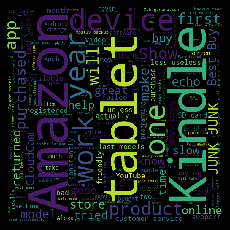

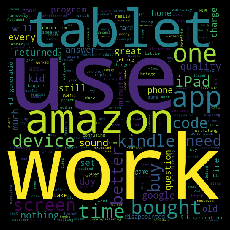

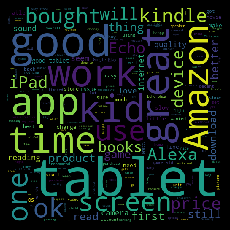

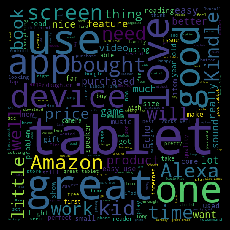

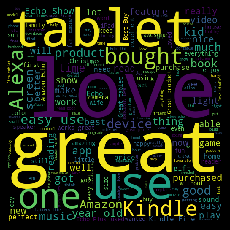

In [74]:
for i in range(1,6):
    reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==i]['reviews.text']))
    reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

    plt.figure(figsize = (5,3), facecolor = 'k')
    plt.imshow(reviewone_wc)
    plt.axis('off')
    plt.tight_layout(pad = 0)
    plt.show()

In [ ]:
mapped_test = station_id.rdd.map(lambda item: (item,1))
mapped_test

In [18]:
# Visualise the 5 different reviews WordCloud and figure other ways to quantify frequency of words
# From - https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73

# WorldCloud - Review == 1 
reviewone = ' '.join(list(amazon_reviews_dataset_pd_df[amazon_reviews_dataset_pd_df['reviews.rating']==1]['reviews.text']))
reviewone_wc = WordCloud(width=512,height=512).generate(reviewone)

plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(reviewone_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

NameError: name 'WordCloud' is not defined

In [23]:
ingrdt = amazon_reviews_dataset_pd_df["reviews.text"].str.split(expand=True).stack().value_counts()
ingrdt.head()
# ingrdt["x"].map(lambda x: x.lower())

# excludedwords = ['the', 'to', 'and','I', 'for','a','it','is','my','this','of','with','on','have','in', 'that', 'was', ]
# # words = "".join(ingrdt)

# counts = {}
# for word in words:
#     counts[word] = counts.get(word,0) + 1
   
# items = list(counts.items())
# # items [('the', 1137), ('tragedy', 1)]

# # key：取哪行， 默认从小到大，reverse = True 从大到小
# items.sort(key = lambda x:x[1], reverse = True)
# for i in range(1000):
#     word, count = items[i]
#     print("{0:<10}{1:>5}".format(word, count))

the    5757
to     4971
and    4926
I      4333
for    3562
dtype: int64

In [0]:
# Set voting values.
ABSTAIN = -1
SPAM = 1 
HAM = 0

In [0]:
# Labelling Funtions for the 5 different review tiers

@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

    @labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

    @labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN
    
    @labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN

In [0]:
# Code to apply all our fucntions
lfs = [#all our functions]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)

In [0]:
# Performance Evaluation

In [0]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")